<a href="https://colab.research.google.com/github/mnijhuis-dnb/open_source_workshop/blob/master/My%20solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests

def download_files(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
file_NAICS = '/NAICS.json'
file_Global_mobility_report = '/Global_mobility_report.csv'
file_US_Hours_Worked = '/US_Hours_Worked.json'
file_PPP_Loan_data = '/PPP_Loan_data.csv'
file_US_zips = '/uszips.xslx'

download_files('1Fe73x8Splw9xY5FOTnpLWENJaBU2tHEy', file_NAICS)
download_files('1d4C6sTuD53tc_Ewbfb1iXascKzDSzDl0', file_Global_mobility_report)
download_files('1KzT1XNA9K0enUv73nwPSkBYp7btg0pvJ', file_US_Hours_Worked)
download_files('1_7s1tH7FVNA5s5gu1vcWxikmGYQ2ryvn', file_PPP_Loan_data)
download_files('1f-ru7e4Ml0d5uzOMGtNpmOQ3kGSr7iT_', file_US_zips)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df_Hours_Worked = pd.read_json(file_US_Hours_Worked)
df_Hours_Worked = pd.merge(df_Hours_Worked, 
              pd.DataFrame(
                  [list(row.values()) for row in df_Hours_Worked['Results']]
                  ,columns=list(df_Hours_Worked['Results'][1]))
              ,left_index=True,right_index=True).drop(columns=['Results'])
              
df_Hours_Worked = pd.merge(df_Hours_Worked, 
              pd.DataFrame(
                  [[dicts['value'] for dicts in row] for row in df_Hours_Worked['data']]
                 ,columns=[dicts['year'] + dicts['period'] for dicts in df_Hours_Worked['data'][77]])
              ,left_index=True,right_index=True).drop(columns=['data'])
df_Hours_Worked['NAICS'] = pd.to_numeric(df_Hours_Worked['NAICS'], errors='coerce')

In [ ]:
df_PPP = pd.read_csv(file_PPP_Loan_data, low_memory=False)
df_PPP.drop(columns=['Unnamed: 0', 'Address', 'BusinessName', 'CD', 'City', 'DateApproved', 'Lender', 'State', 'Gender', 'NonProfit', 'Veteran'], inplace=True)
df_PPP['NAICSCode'] = pd.to_numeric(df_PPP['NAICSCode'], errors='coerce')
df_PPP['LoanAmount'] = pd.to_numeric(df_PPP['LoanAmount'], errors='coerce')
df_PPP['JobsRetained'] = pd.to_numeric(df_PPP['JobsRetained'], errors='coerce')

In [ ]:
print(df_PPP['LoanRange'].unique())

['a $5-10 million' 'b $2-5 million' 'c $1-2 million'
 'd $350,000-1 million' 'e $150,000-350,000' nan]


In [ ]:
df_PPP.loc[df_PPP['LoanRange']=='a $5-10 million','LoanRange'] = 7000000
df_PPP.loc[df_PPP['LoanRange']=='b $2-5 million','LoanRange'] = 3000000
df_PPP.loc[df_PPP['LoanRange']=='c $1-2 million','LoanRange'] = 1500000
df_PPP.loc[df_PPP['LoanRange']=='d $350,000-1 million','LoanRange'] = 700000
df_PPP.loc[df_PPP['LoanRange']=='e $150,000-350,000','LoanRange'] = 250000
df_PPP['LoanRange'] = pd.to_numeric(df_PPP['LoanRange'], errors='coerce')

In [ ]:
df_PPP['LoanRange'].fillna(0,inplace=True)
df_PPP['LoanAmount'].fillna(0,inplace=True)
df_PPP['LoanAmount'] = df_PPP['LoanAmount'] + df_PPP['LoanRange']
df_PPP.drop(columns='LoanRange',inplace=True)

In [ ]:
df_NAICS = pd.read_json(file_NAICS)
df_NAICS.reset_index(drop=False, inplace=True)
df_NAICS = df_NAICS.rename(columns={'index': 'NAICS_code'})
df_NAICS['NAICS_code'] = pd.to_numeric(df_NAICS['NAICS_code'], errors='coerce')
df_NAICS.dropna(inplace=True)

In [ ]:
df_Hours_Worked.drop(columns=['status','responseTime', 'seriesID'],inplace=True)
col_Hours_Worked = df_Hours_Worked.columns.drop('NAICS')
df_Hours_Worked[col_Hours_Worked] = df_Hours_Worked[col_Hours_Worked].apply(pd.to_numeric, errors='coerce')
df_Hours_Worked['change'] = df_Hours_Worked['2019M05'] - df_Hours_Worked['2020M05']
col_Hours_Worked = df_Hours_Worked.columns.drop(['NAICS','change'])
df_Hours_Worked.drop(columns=list(col_Hours_Worked), inplace=True)

In [ ]:
df_PPP_pivot = pd.pivot_table(df_PPP, values=['LoanAmount','JobsRetained'],index='NAICSCode', aggfunc='sum').reset_index(drop=False, inplace=False)

In [ ]:
df_PPP_sector = pd.merge(pd.merge(df_PPP_pivot, df_Hours_Worked, how='left', left_on='NAICSCode', right_on='NAICS'), df_NAICS, how='left', left_on='NAICS', right_on='NAICS_code')

In [ ]:
print(df_PPP_sector['LoanAmount'].sum())
print(df_PPP_sector.dropna()['LoanAmount'].sum())
df_PPP_sector.dropna(inplace=True)

557694744561.8048
329357225349.1605


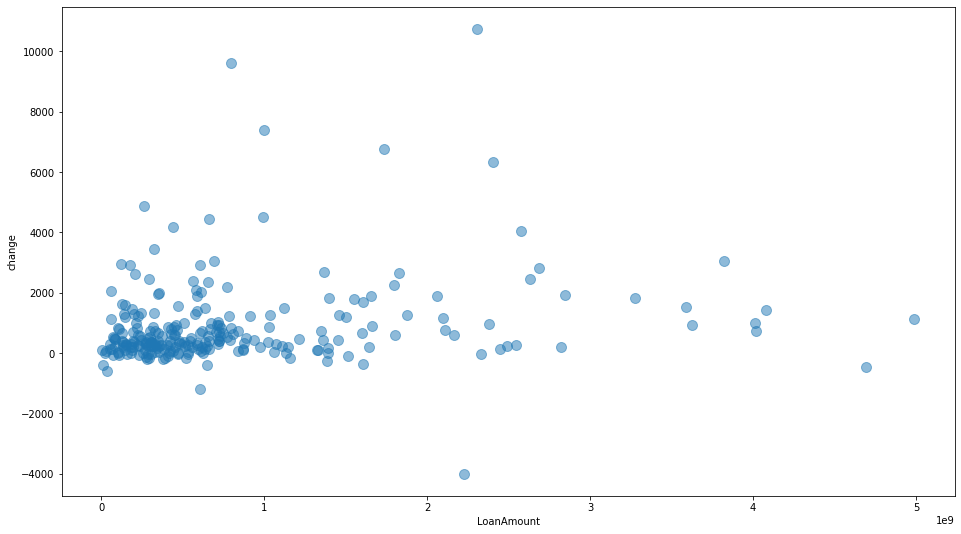

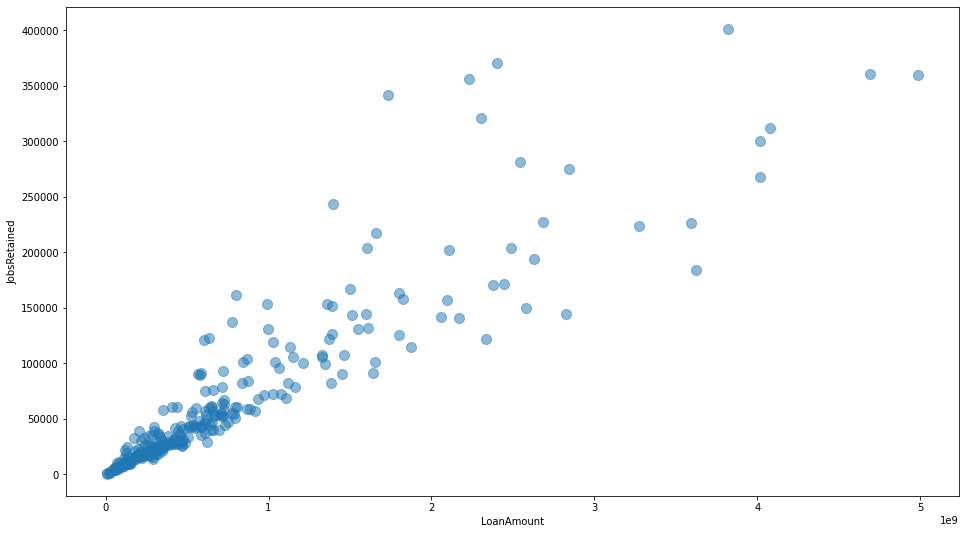

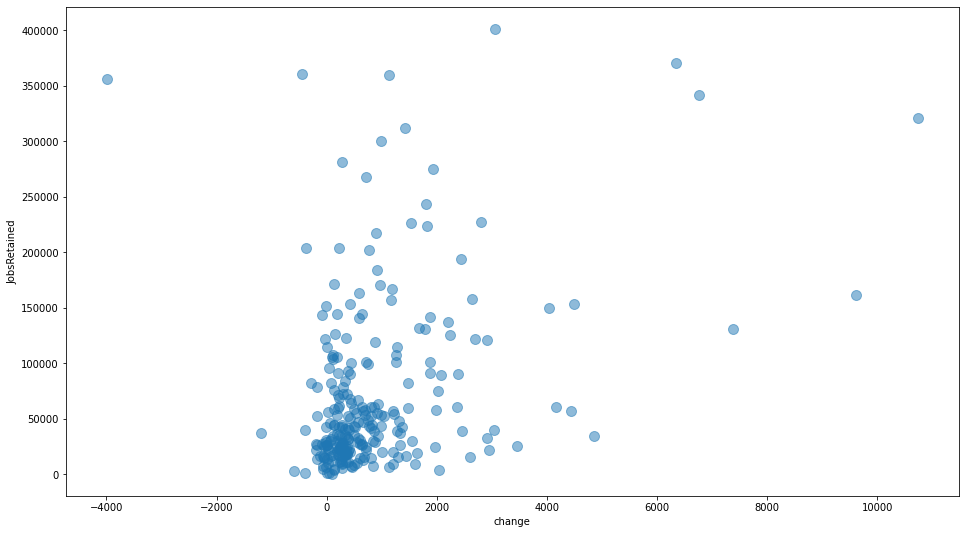

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
df_PPP_sector[(df_PPP_sector['change']<20000) & (df_PPP_sector['LoanAmount']<5000000000)].plot.scatter(x='LoanAmount',y='change', alpha=0.5, s=100)
df_PPP_sector[(df_PPP_sector['change']<20000) & (df_PPP_sector['LoanAmount']<5000000000)].plot.scatter(x='LoanAmount',y='JobsRetained', alpha=0.5, s=100)
df_PPP_sector[(df_PPP_sector['change']<20000) & (df_PPP_sector['LoanAmount']<5000000000)].plot.scatter(x='change',y='JobsRetained', alpha=0.5, s=100)

In [ ]:
df_PPP_sector.corr(method='pearson')

,NAICSCode,JobsRetained,LoanAmount,NAICS,change,NAICS_code
NAICSCode,1.000000,0.117208,0.019672,1.000000,0.139625,1.000000
JobsRetained,0.117208,1.000000,0.899540,0.117208,0.887770,0.117208
LoanAmount,0.019672,0.899540,1.000000,0.019672,0.684521,0.019672
NAICS,1.000000,0.117208,0.019672,1.000000,0.139625,1.000000
change,0.139625,0.887770,0.684521,0.139625,1.000000,0.139625
NAICS_code,1.000000,0.117208,0.019672,1.000000,0.139625,1.000000


In [ ]:
df_PPP_sector['extra'] = df_PPP_sector['change']/df_PPP_sector['LoanAmount']
df_PPP_sector.sort_values(by='extra', inplace=True)
df_PPP_sector.head(5)

,NAICSCode,JobsRetained,LoanAmount,NAICS,change,NAICS_code,2017 NAICS US Title,extra
895,522190.0,800.0,9.950234e+06,522190.0,-398.0,522190.0,Other Depository Credit Intermediation,-0.000040
892,522110.0,2651.0,3.231191e+07,522110.0,-602.0,522110.0,Commercial Banking,-0.000019
899,522292.0,36834.0,6.079066e+08,522292.0,-1198.0,522292.0,Real Estate Credit,-0.000002
726,445110.0,355631.0,2.228787e+09,445110.0,-3999.0,445110.0,Supermarkets and Other Grocery (except Conveni...,-0.000002
80,212312.0,4635.0,7.312327e+07,212312.0,-74.0,212312.0,Crushed and Broken Limestone Mining and Quarry...,-0.000001


In [ ]:
df_PPP_sector.tail(5)

,NAICSCode,JobsRetained,LoanAmount,NAICS,change,NAICS_code,2017 NAICS US Title,extra
893,522120.0,534.0,5.652218e+06,522120.0,98.0,522120.0,Savings Institutions,0.000017
190,311813.0,6594.0,6.097855e+07,311813.0,1129.0,311813.0,"Frozen Cakes, Pies, and Other Pastries Manufac...",0.000019
745,448140.0,34231.0,2.597501e+08,448140.0,4856.0,448140.0,Family Clothing Stores,0.000019
1156,722330.0,21377.0,1.203894e+08,722330.0,2944.0,722330.0,Mobile Food Services,0.000024
973,541340.0,4163.0,6.041694e+07,541340.0,2045.0,541340.0,Drafting Services,0.000034
